# Imports

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn import datasets
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

Using TensorFlow backend.


# Setup

In [2]:
# Mount CU Drive
from google.colab import drive
drive.mount('/content/drive')

!mkdir drive/My\ Drive/synthetic-ds
!mkdir drive/My\ Drive/synthetic-ds/ct2
!mkdir drive/My\ Drive/synthetic-ds/ctp2
!mkdir drive/My\ Drive/synthetic-ds/ct2-28
!mkdir drive/My\ Drive/synthetic-ds/ctp2-28
!mkdir drive/My\ Drive/synthetic-ds/squares
!mkdir drive/My\ Drive/synthetic-ds/point
!mkdir drive/My\ Drive/synthetic-ds/point/circles
!mkdir drive/My\ Drive/synthetic-ds/point/s_curves
!mkdir drive/My\ Drive/synthetic-ds/point/swiss_roll
!mkdir drive/My\ Drive/synthetic-ds/point/blobs

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ct2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ctp2’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ct2-28’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/ctp2-28’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/squares’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point/circles’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point/s_curves’: File exists
mkdir: cannot create directory ‘drive/My Drive/synthetic-ds/point/swiss_roll’: File exists
mkdir: cannot create directory ‘drive/My Drive/

# Image Dataset Generation

## Squares

### Generation

In [0]:
def get_sample(mean, stdev):
    return np.random.multivariate_normal(mean, (stdev**2)*np.identity(2))

def gen_mixture(no_of_dist, dataset_size, scaling_factor = (100, 10)):
    # Generate means and stdev of the mixture
    mean = np.random.rand(no_of_dist, 2)* scaling_factor[0]
    stdev = np.random.rand(no_of_dist)* scaling_factor[1]

    # Generate dataset
    idx = np.random.randint(0, high = no_of_dist, size = dataset_size)
    mean_arr = mean[idx]
    stdev_arr = stdev[idx]

    data = np.zeros((dataset_size, 2))
    for i in range(dataset_size):
        data[i] = get_sample(mean_arr[i], stdev_arr[i])
    
    return idx, data, mean, stdev

# Fixed size of images : 64 x 64 x 1
# For simplicity keep size of squares to be exponents of 2 i.e. 2, 4, 8 ...
def draw_square(im, square_size, im_size, top_left = None):
    if top_left is None:
      top_left = np.random.randint(0, high = im_size - square_size, size = 2)
    
    # Set colour 
    im[top_left[0] : top_left[0] + square_size, top_left[1] : top_left[1] + square_size] = 1

    return im, top_left

def non_overlapping_square(im, no_of_squares, square_size, im_size):
    bad_corners = True
    while bad_corners:
        top_left = np.random.randint(0, high = im_size - square_size - 1, size = (no_of_squares, 2))
        new_im = np.copy(im)
        found_combination = False
        for i in range(0, no_of_squares):
            relevant_square = new_im[top_left[i][0]: top_left[i][0] + square_size, top_left[i][1] : top_left[i][1] + square_size] 
            neighbors = relevant_square[relevant_square == 1]
            if neighbors.shape[0] == 0:
                draw_square(new_im, square_size, im_size, top_left[i])
                if i == no_of_squares - 1:
                    found_combination = True
            else:
                bad_corners = True
                break

        if bad_corners and not found_combination:
            continue
        bad_corners = False
    return new_im



def gen_square_image(no_of_squares, square_size, overlap, im_size):
    im = np.zeros((im_size, im_size))

    idx = []
    if overlap:
        for i in range(no_of_squares):
            im, ind = draw_square(im, square_size, im_size)
            idx.append(ind)
    else:
        im = non_overlapping_square(im, no_of_squares, square_size, im_size)

    return im
  
def gen_square_dataset(no_of_squares, square_size, dataset_size, overlap, im_size = 128):
  ds = np.zeros((dataset_size, im_size, im_size))
  for i in range(dataset_size):
    ds[i] = gen_square_image(no_of_squares, square_size, overlap, im_size)
  return ds

In [0]:
# Save dataset with 1 square of size 32 
ds = gen_square_dataset(1, 32, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/1-32.npy", ds)

# Save dataset with 4 squares of size 16 
ds = gen_square_dataset(4, 16, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/4-16.npy", ds)

# Save dataset with 10 squares of size 8 
ds = gen_square_dataset(10, 8, 5000, False)
np.save("drive/My Drive/synthetic-ds/squares/10-8.npy", ds)

# Save dataset with 1 square of size 16 in 28x28
ds = gen_square_dataset(1, 16, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/1-16-28x28.npy", ds)

# Save dataset with 3 squares of size 4 
ds = gen_square_dataset(3, 4, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/3-4-28x28.npy", ds)

# Save dataset with 1 square of size 4 
ds = gen_square_dataset(1, 4, 5000, False, im_size = 28)
np.save("drive/My Drive/synthetic-ds/squares/1-4-28x28.npy", ds)

### Load

In [0]:
squares_1_32 = np.load("drive/My Drive/synthetic-ds/squares/1-32.npy")
squares_4_16 = np.load("drive/My Drive/synthetic-ds/squares/4-16.npy")
squares_10_8 = np.load("drive/My Drive/synthetic-ds/squares/10-8.npy")
squares_1_16_28 = np.load("drive/My Drive/synthetic-ds/squares/1-16-28x28.npy")
squares_3_4_28 = np.load("drive/My Drive/synthetic-ds/squares/3-4-28x28.npy")
squares_1_4_28 = np.load("drive/My Drive/synthetic-ds/squares/1-4-28x28.npy")

## Mixture of Polygons

### Code

In [0]:
def generate_ct2(im_path, im_size):
  image = Image.new('RGB', (im_size, im_size))
  image.save(im_path, "PNG")
  
  image = Image.open(im_path)
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save(im_path)
  
def generate_ctp2(im_path, im_size):
  # Create new image (all black)
  image = Image.new('RGB', (im_size, im_size))
  draw = ImageDraw.Draw(image)

  # Draw 2 circles
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  x = np.random.randint(10, high = im_size - 10)
  y = np.random.randint(10, high = im_size - 10)
  r = np.random.randint(min(x, y, im_size - x, im_size - y))
  draw.ellipse((x-r, y-r, x+r, y+r), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 triangles
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  # Draw 2 polygons (4 sided)
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))
  
  points = ((np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)), (np.random.randint(im_size), np.random.randint(im_size)))
  draw.polygon((points), fill= (np.random.randint(256), np.random.randint(256), np.random.randint(256)))

  image.save(im_path)

def gen_image_dataset(image_name, im_size, dataset_size, image_generator, path):
  im_path = path + image_name
  for i in range(dataset_size):
    image_generator(im_path + str(i) + '.png', im_size)

### Generation

In [29]:
gen_image_dataset('image', 128, 5000, generate_ct2, 'drive/My Drive/synthetic-ds/ct2/')
gen_image_dataset('image', 128, 5000, generate_ctp2, 'drive/My Drive/synthetic-ds/ctp2/')

KeyboardInterrupt: ignored

In [0]:
gen_image_dataset('image', 28, 5000, generate_ct2, 'drive/My Drive/synthetic-ds/ct2-28/')
gen_image_dataset('image', 28, 5000, generate_ctp2, 'drive/My Drive/synthetic-ds/ctp2-28/')

### Utilites for testing

In [24]:
# Check if the files have been generated 
!ls drive/My\ Drive/synthetic-ds/ct2/
!ls drive/My\ Drive/synthetic-ds/ctp2/

image0.png     image1900.png  image2800.png  image3700.png  image4600.png
image1000.png  image1901.png  image2801.png  image3701.png  image4601.png
image1001.png  image1902.png  image2802.png  image3702.png  image4602.png
image1002.png  image1903.png  image2803.png  image3703.png  image4603.png
image1003.png  image1904.png  image2804.png  image3704.png  image4604.png
image1004.png  image1905.png  image2805.png  image3705.png  image4605.png
image1005.png  image1906.png  image2806.png  image3706.png  image4606.png
image1006.png  image1907.png  image2807.png  image3707.png  image4607.png
image1007.png  image1908.png  image2808.png  image3708.png  image4608.png
image1008.png  image1909.png  image2809.png  image3709.png  image4609.png
image1009.png  image190.png   image280.png   image370.png   image460.png
image100.png   image1910.png  image2810.png  image3710.png  image4610.png
image1010.png  image1911.png  image2811.png  image3711.png  image4611.png
image1011.png  image1912.png  image2812

In [0]:
# Delete all files in relevant folders
!rm drive/My\ Drive/synthetic-ds/ct2/*
!rm drive/My\ Drive/synthetic-ds/ctp2/*

rm: cannot remove 'drive/My Drive/synthetic-ds/ctp2/*': No such file or directory


# Point (in $R^n$) Dataset Generation 

## Circles

### Generation

In [0]:
circle_factor_1 = datasets.make_circles(n_samples = 5000, factor = 0.1, random_state = 0)
circle_factor_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, random_state = 0)
circle_factor_9 = datasets.make_circles(n_samples = 5000, factor = 0.9, random_state = 0)

circle_noise_5 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.05, random_state = 0)
circle_noise_10 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.1, random_state = 0)
circle_noise_50 = datasets.make_circles(n_samples = 5000, factor = 0.5, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_1', np.column_stack((circle_factor_1[0], circle_factor_1[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_5', np.column_stack((circle_factor_5[0], circle_factor_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_factor_9', np.column_stack((circle_factor_9[0], circle_factor_9[1])))

np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_5', np.column_stack((circle_noise_5[0], circle_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_10', np.column_stack((circle_noise_10[0], circle_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/circles/circle_noise_50', np.column_stack((circle_noise_50[0], circle_noise_50[1])))

### Load

In [0]:
circle_factor_1 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_1.npy')
circle_factor_5 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_5.npy')
circle_factor_9 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_factor_9.npy')

circle_noise_5 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_5.npy')
circle_noise_10 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_10.npy')
circle_noise_50 = np.load('drive/My Drive/synthetic-ds/point/circles/circle_noise_50.npy')

## S Curve

### Generation

In [0]:
scurve_noise_5 = datasets.make_s_curve(n_samples = 5000, noise = 0.05, random_state = 0)
scurve_noise_10 = datasets.make_s_curve(n_samples = 5000, noise = 0.1, random_state = 0)
scurve_noise_50 = datasets.make_s_curve(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_5', np.column_stack((scurve_noise_5[0], scurve_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_10', np.column_stack((scurve_noise_10[0], scurve_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_50', np.column_stack((scurve_noise_50[0], scurve_noise_50[1])))

### Load

In [0]:
scurve_noise_5 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_5.npy')
scurve_noise_10 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_10.npy')
scurve_noise_50 = np.load('drive/My Drive/synthetic-ds/point/s_curves/scurve_noise_50.npy')

## Swiss Roll

### Generation

In [0]:
roll_noise_5 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.05, random_state = 0)
roll_noise_10 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.1, random_state = 0)
roll_noise_50 = datasets.make_swiss_roll(n_samples = 5000, noise = 0.5, random_state = 0)

In [0]:
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_5', np.column_stack((roll_noise_5[0], roll_noise_5[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_10', np.column_stack((roll_noise_10[0], roll_noise_10[1])))
np.save('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_50', np.column_stack((roll_noise_50[0], roll_noise_50[1])))

### Load

In [0]:
roll_noise_5 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_5.npy')
roll_noise_10 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_10.npy')
roll_noise_50 = np.load('drive/My Drive/synthetic-ds/point/swiss_roll/roll_noise_50.npy')

## Clusters

### Generation

In [0]:
blobs_3 = datasets.make_blobs(n_samples = 5000, centers = 3, random_state = 100)

### Load

In [0]:
np.save('drive/My Drive/synthetic-ds/point/blobs/blobs_3', blobs_3[0])

In [10]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, input_dim=self.latent_dim))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        '''
        
        X_train = np.load('drive/My Drive/synthetic-ds/squares/3-4-28x28.npy')
        X_train = X_train/0.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        '''
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            print(epoch)
            
            if epoch%1000 == 0:
              # Plot the progress
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=300000, batch_size=32, save_interval=2000)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1

KeyboardInterrupt: ignored

In [0]:
!mkdir images
!rm images/*

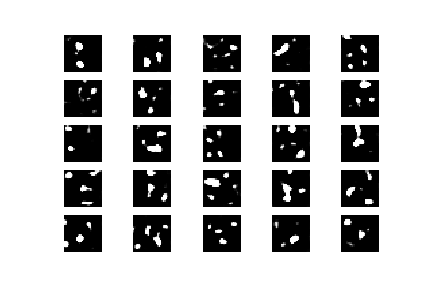

In [0]:
from IPython.display import Image
Image(filename='images/mnist_1000.png')

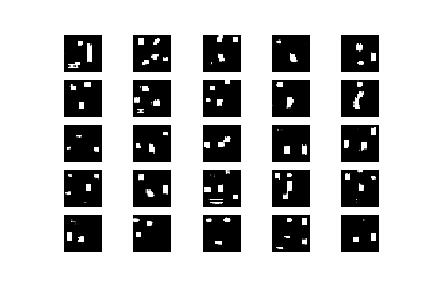

In [0]:
from IPython.display import Image
Image(filename='images/mnist_9000.png')

In [0]:
!mkdir images/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 7.855456] [G loss: 0.146099]


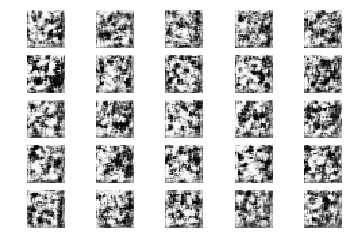

1000 [D loss: -1.302932] [G loss: -2.118618]
2000 [D loss: -15.699497] [G loss: -4.183551]
3000 [D loss: -141.554596] [G loss: 37.967831]
4000 [D loss: -568.693665] [G loss: 237.448700]
5000 [D loss: -1139.140259] [G loss: 566.467529]


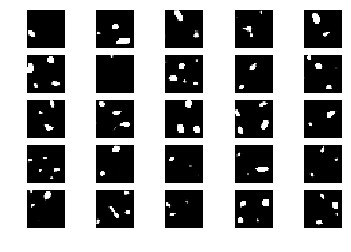

6000 [D loss: -2059.554443] [G loss: 938.604248]
7000 [D loss: -3006.733154] [G loss: 1380.937256]
8000 [D loss: -3878.059814] [G loss: 1954.531982]
9000 [D loss: -5269.432129] [G loss: 2552.799805]
10000 [D loss: -6454.338379] [G loss: 2452.273438]


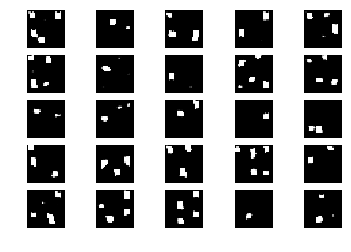

11000 [D loss: -7410.288574] [G loss: 3552.403320]
12000 [D loss: -6878.112305] [G loss: 3836.232178]
13000 [D loss: -10562.203125] [G loss: 4932.034180]
14000 [D loss: -12387.833984] [G loss: 5379.541016]
15000 [D loss: -8654.008789] [G loss: 1498.373901]


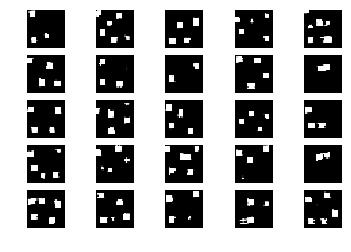

16000 [D loss: -13135.960938] [G loss: 6995.442871]
17000 [D loss: -12946.831055] [G loss: 7308.387695]
18000 [D loss: -16242.225586] [G loss: 8145.681152]
19000 [D loss: -17621.542969] [G loss: 8993.403320]
20000 [D loss: -20575.152344] [G loss: 8434.882812]


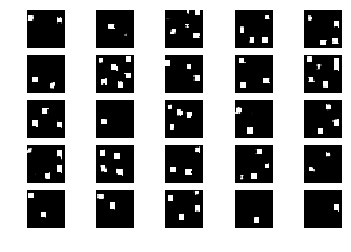

21000 [D loss: -23048.980469] [G loss: 10319.177734]
22000 [D loss: -23270.968750] [G loss: 9628.841797]
23000 [D loss: -24325.226562] [G loss: 10356.839844]
24000 [D loss: -23185.109375] [G loss: 11722.507812]
25000 [D loss: -19402.769531] [G loss: 5118.943359]


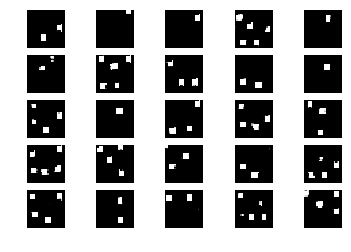

26000 [D loss: -30186.027344] [G loss: 11383.818359]
27000 [D loss: -20126.667969] [G loss: 10804.050781]
28000 [D loss: -34412.921875] [G loss: 12066.712891]
29000 [D loss: -38129.648438] [G loss: 13360.785156]
30000 [D loss: -41219.882812] [G loss: 16246.666992]


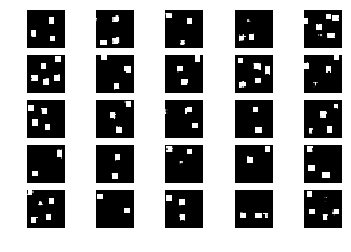

31000 [D loss: -28402.929688] [G loss: 10715.083008]
32000 [D loss: -34465.457031] [G loss: 10832.306641]
33000 [D loss: -37208.539062] [G loss: 18586.640625]
34000 [D loss: -27135.185547] [G loss: 11873.221680]
35000 [D loss: -44524.843750] [G loss: 17929.742188]


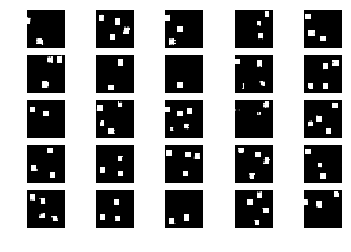

36000 [D loss: -44435.566406] [G loss: 20660.378906]
37000 [D loss: -53573.070312] [G loss: 18781.080078]
38000 [D loss: -52649.675781] [G loss: 14165.533203]
39000 [D loss: -51918.125000] [G loss: 20337.337891]
40000 [D loss: -49471.671875] [G loss: 9786.738281]


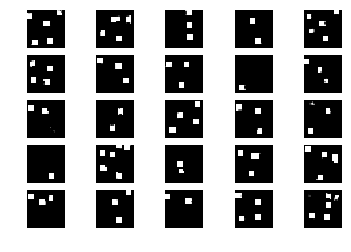

41000 [D loss: -59574.503906] [G loss: 24155.097656]
42000 [D loss: -56584.234375] [G loss: 22025.183594]
43000 [D loss: -62712.664062] [G loss: 20434.046875]
44000 [D loss: -70763.492188] [G loss: 19548.687500]
45000 [D loss: -33729.843750] [G loss: 21461.464844]


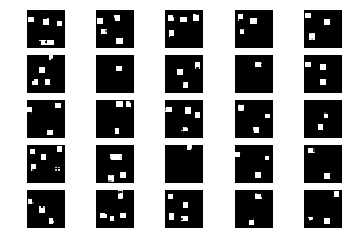

46000 [D loss: -43227.312500] [G loss: 20711.587891]
47000 [D loss: -71088.976562] [G loss: 25653.570312]
48000 [D loss: -73676.476562] [G loss: 25212.566406]
49000 [D loss: -69835.937500] [G loss: 29588.769531]
50000 [D loss: -50623.917969] [G loss: 20303.144531]


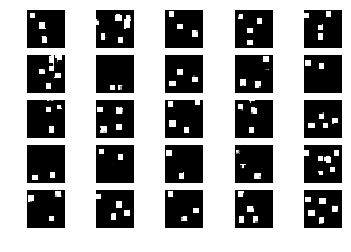

51000 [D loss: -34363.453125] [G loss: 25526.714844]
52000 [D loss: -75081.078125] [G loss: 31666.283203]
53000 [D loss: -75591.031250] [G loss: 10140.683594]
54000 [D loss: -78422.625000] [G loss: 29182.005859]
55000 [D loss: -100523.390625] [G loss: 12558.621094]


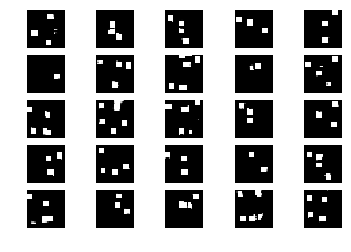

56000 [D loss: -88148.757812] [G loss: 33854.460938]
57000 [D loss: -33704.222656] [G loss: -25519.957031]
58000 [D loss: -81386.117188] [G loss: 22630.142578]
59000 [D loss: -80420.234375] [G loss: 19672.902344]
60000 [D loss: -80990.992188] [G loss: -20205.179688]


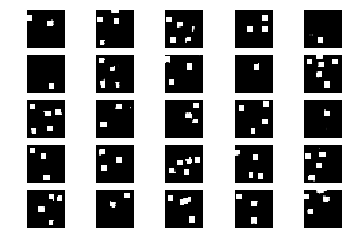

61000 [D loss: -87400.398438] [G loss: 34502.984375]
62000 [D loss: -71904.195312] [G loss: 31259.242188]
63000 [D loss: -20753.046875] [G loss: 30518.769531]
64000 [D loss: -51424.753906] [G loss: 35991.195312]
65000 [D loss: -106379.125000] [G loss: 33975.964844]


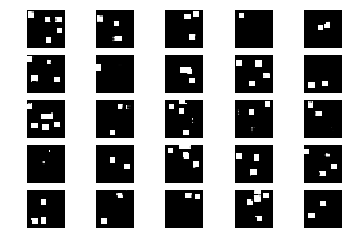

66000 [D loss: -57526.105469] [G loss: 35031.003906]
67000 [D loss: -59230.886719] [G loss: 43783.261719]
68000 [D loss: -91973.468750] [G loss: 19492.750000]
69000 [D loss: -85032.250000] [G loss: 11710.132812]
70000 [D loss: -117218.203125] [G loss: 37787.031250]


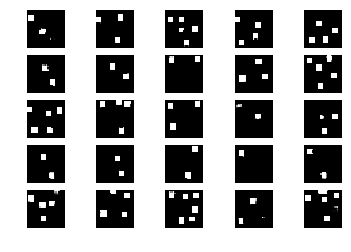

71000 [D loss: -98708.328125] [G loss: 16556.550781]
72000 [D loss: -78097.625000] [G loss: 40743.410156]
73000 [D loss: -81614.187500] [G loss: 31830.705078]
74000 [D loss: -22817.455078] [G loss: 41138.632812]
75000 [D loss: -101946.023438] [G loss: 38832.148438]


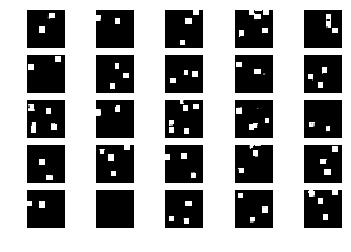

76000 [D loss: -98244.757812] [G loss: 25345.750000]
77000 [D loss: -94644.765625] [G loss: 2808.748535]
78000 [D loss: -45218.023438] [G loss: 8628.068359]
79000 [D loss: -102334.125000] [G loss: 15368.356445]
80000 [D loss: -119495.921875] [G loss: -39031.273438]


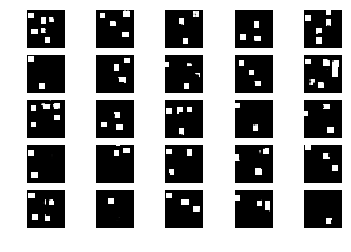

81000 [D loss: -68548.453125] [G loss: 39013.218750]
82000 [D loss: -115002.414062] [G loss: 39038.296875]
83000 [D loss: -44380.843750] [G loss: 27769.951172]
84000 [D loss: -152480.828125] [G loss: 48999.714844]
85000 [D loss: -141034.921875] [G loss: 42099.570312]


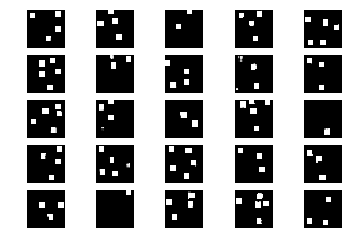

86000 [D loss: -94417.976562] [G loss: 8900.923828]
87000 [D loss: -67756.500000] [G loss: 32977.652344]
88000 [D loss: -73923.578125] [G loss: 25247.175781]
89000 [D loss: -130181.765625] [G loss: -434.780029]
90000 [D loss: -130009.109375] [G loss: 15416.886719]


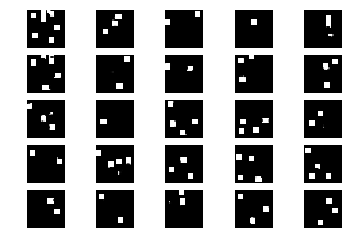

91000 [D loss: -164023.531250] [G loss: 47478.261719]
92000 [D loss: -63002.023438] [G loss: 23701.191406]
93000 [D loss: -137085.781250] [G loss: 39598.179688]
94000 [D loss: -111428.046875] [G loss: 9675.722656]
95000 [D loss: -171401.296875] [G loss: 31371.957031]


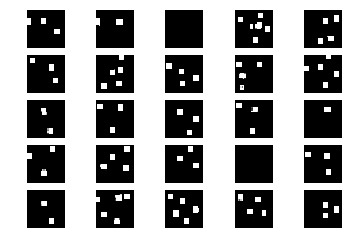

96000 [D loss: -86832.921875] [G loss: -12190.583984]
97000 [D loss: -137042.546875] [G loss: 20721.531250]
98000 [D loss: -98608.867188] [G loss: 41197.898438]
99000 [D loss: -81010.328125] [G loss: 37484.789062]


In [9]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

from PIL import Image

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_img = self.generator(z_disc)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)


    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size, sample_interval=50):
        '''
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        '''
        X_train = np.load('drive/My Drive/synthetic-ds/squares/3-4-28x28.npy')
        X_train = X_train/0.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        print(X_train.shape)
        
        #X_train += np.reshape(np.random.normal(0, 0.1, X_train.shape[0]*X_train.shape[1]*X_train.shape[2]*X_train.shape[3]), X_train.shape)
        
        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise],
                                                                [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(noise, valid)
            
            if epoch%1000 == 0:
              # Plot the progress
              print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
              self.generator.save('gen_model')
              self.critic.save('critic_model')

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
                # Save Snapshots of models, losses and samples
                
                # Save model snapshots
                model_dir = self.save_path + '/models/' + str(epoch) + '/'
                pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True) 
                self.generator.save(model_dir + 'gen_' + str(epoch) + '.h5')
                self.critic.save(model_dir + 'critic_' + str(epoch) + '.h5')
                
                # Save Losses
                loss_dir = self.save_path + '/loss/' + str(epoch) + '/'
                pathlib.Path(loss_dir).mkdir(parents=True, exist_ok=True) 
                np.save(loss_dir + 'critic_loss', np.array(disc_loss))
                np.save(loss_dir + 'gen_loss', np.array(gen_loss))
                
                # Plot and Save samples
                sample_dir = self.save_path + '/samples/' + str(epoch) + '/'
                self.sample_images(epoch, sample_dir)

    def sample_images(self, epoch, sample_dir):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        pathlib.Path(sample_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(sample_dir + 'sample.png')
        plt.show()
        plt.close()
       


if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=100000, batch_size=32, sample_interval=5000)

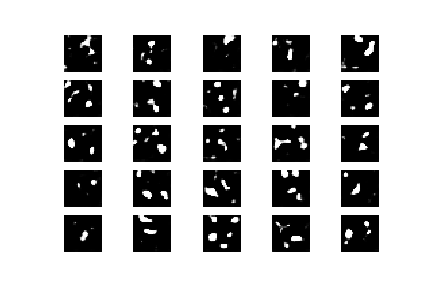

In [0]:
from IPython.display import Image
Image(filename='images/mnist_1000.png')

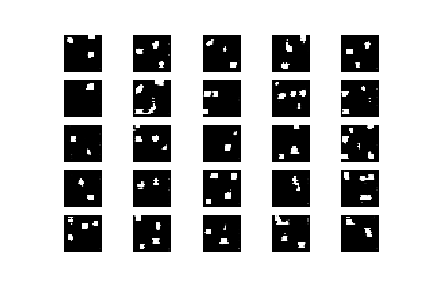

In [0]:
from IPython.display import Image
Image(filename='images/mnist_9000.png')

In [0]:
!ls

ak.jpg				gdrive		     LICENSE
architecture.svg		gen_model	     mkdocs.yml
CaltechAUTHORS:CNS-TR-2007-001	headers.py	     README.rst
critic_model			images		     sample_data
docs				importance_sampling  scripts
drive				importance-sampling  setup.py
examples			__init__.py	     tests


# New test

In [3]:
!rm images/*
!mkdir images

rm: cannot remove 'images/loss': Is a directory
rm: cannot remove 'images/models': Is a directory
rm: cannot remove 'images/samples': Is a directory
mkdir: cannot create directory ‘images’: File exists


In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os
import pathlib
import glob
import shutil
import sklearn.datasets

from PIL import Image

import numpy as np
from keras.models import load_model

In [0]:
class DCGAN():
    def __init__(self, X_train, img_shape, latent_dim, save_path, pretrained = None):
        # Input shape
        self.img_rows = img_shape[0]
        self.img_cols = img_shape[1]
        self.channels = img_shape[2]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim
        self.dataset = X_train
        self.save_path = save_path

        optimizer = Adam(0.0002, 0.5)

        if pretrained is None:
          # Build and compile the discriminator
          self.discriminator = self.build_discriminator()
          self.discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

          # Build the generator
          self.generator = self.build_generator()
        else:
          self.generator = load_model(pretrained + '/gen_40000.h5')
          
          self.discriminator = load_model(pretrained + '/disc_40000.h5')
          
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, input_dim=self.latent_dim))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation("relu"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50, scaling = 0.5):

        
        X_train = self.dataset

        # Rescale -1 to 1
        X_train = X_train / scaling - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
                 
        gen_loss = []
        disc_loss = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            gen_loss.append(g_loss)
            disc_loss.append(d_loss[0])
            
            if epoch%sample_interval == 0:
              # Plot the progress
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:                
                # Save Snapshots of models, losses and samples
                
                # Save model snapshots
                model_dir = self.save_path + '/models/' + str(epoch) + '/'
                pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True) 
                self.generator.save(model_dir + 'gen_' + str(epoch) + '.h5')
                self.discriminator.save(model_dir + 'disc_' + str(epoch) + '.h5')
                
                # Save Losses
                loss_dir = self.save_path + '/loss/' + str(epoch) + '/'
                pathlib.Path(loss_dir).mkdir(parents=True, exist_ok=True) 
                np.save(loss_dir + 'critic_loss', np.array(disc_loss))
                np.save(loss_dir + 'gen_loss', np.array(gen_loss))
                
                # Plot and Save samples
                sample_dir = self.save_path + '/samples/' + str(epoch) + '/'
                self.sample_images(epoch, sample_dir, scaling)

    def sample_images(self, epoch, sample_dir, scaling):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = scaling * (gen_imgs + 1)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        pathlib.Path(sample_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(sample_dir + 'sample.png')
        plt.show()
        plt.close()

## MNIST DCGAN 30k Iters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.377190, acc.: 46.88%] [G loss: 0.352314]


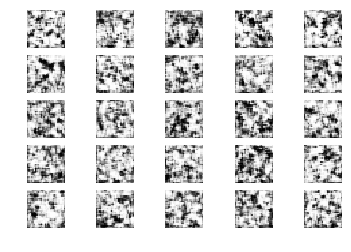

2000 [D loss: 0.686774, acc.: 56.25%] [G loss: 0.966782]


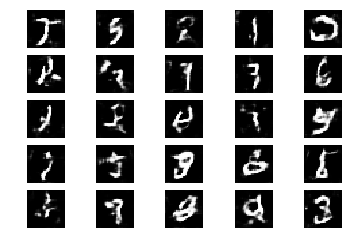

4000 [D loss: 0.547432, acc.: 70.31%] [G loss: 1.190082]


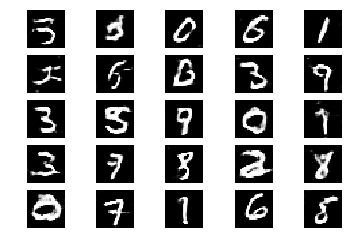

6000 [D loss: 0.650112, acc.: 64.06%] [G loss: 1.147474]


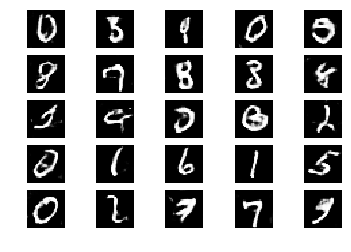

8000 [D loss: 0.784758, acc.: 50.00%] [G loss: 1.026073]


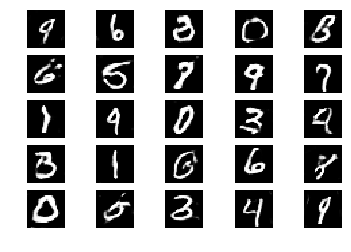

10000 [D loss: 0.616910, acc.: 68.75%] [G loss: 1.228601]


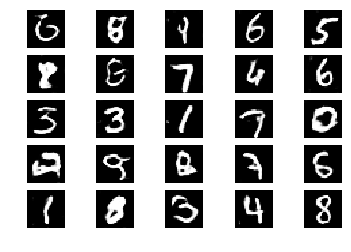

12000 [D loss: 0.584174, acc.: 71.88%] [G loss: 1.093284]


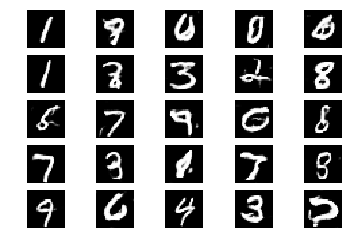

14000 [D loss: 0.643973, acc.: 59.38%] [G loss: 1.352343]


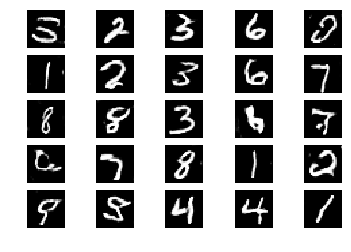

16000 [D loss: 0.440651, acc.: 82.81%] [G loss: 1.382631]


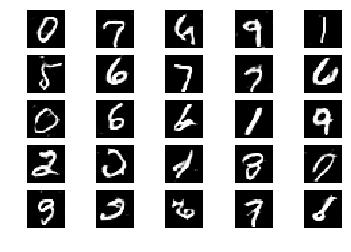

18000 [D loss: 0.358786, acc.: 84.38%] [G loss: 2.581309]


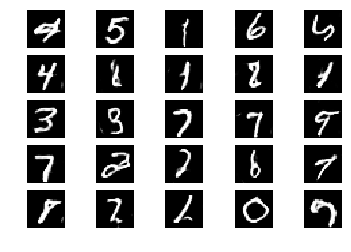

20000 [D loss: 0.478563, acc.: 73.44%] [G loss: 2.224387]


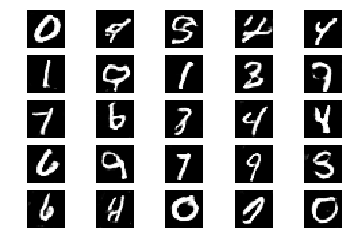

22000 [D loss: 0.530258, acc.: 73.44%] [G loss: 3.014009]


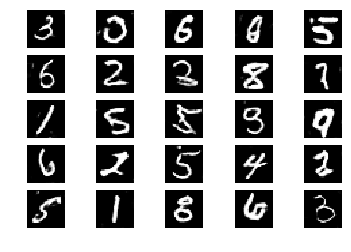

24000 [D loss: 0.147009, acc.: 98.44%] [G loss: 3.202116]


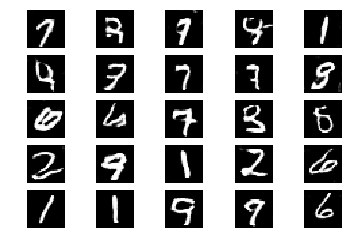

26000 [D loss: 0.481021, acc.: 71.88%] [G loss: 1.368529]


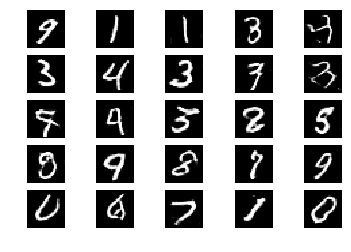

28000 [D loss: 0.198465, acc.: 98.44%] [G loss: 0.942372]


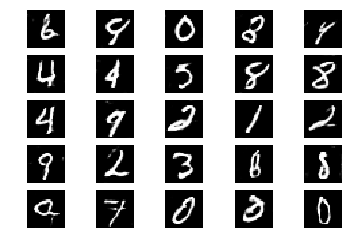

In [23]:

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

img_shape = (28,28,1)
latent_dim = 100
save_path = 'images'
n_iter = 30000
scaling = 127.5
model_class = DCGAN
  
# Train model
gan = model_class(X_train, img_shape, latent_dim, save_path)
gan.train(n_iter, 32, 2000, scaling)

## MNIST DCGAN 70k Iters

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.095098, acc.: 32.81%] [G loss: 0.845059]


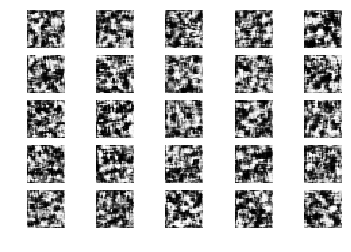

2000 [D loss: 0.718059, acc.: 60.94%] [G loss: 0.962401]


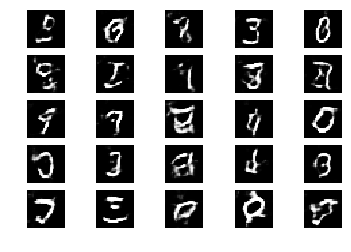

4000 [D loss: 0.677736, acc.: 56.25%] [G loss: 0.922375]


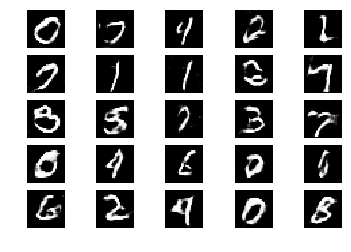

6000 [D loss: 0.717803, acc.: 62.50%] [G loss: 1.009371]


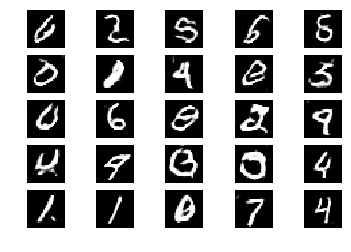

8000 [D loss: 0.567939, acc.: 75.00%] [G loss: 1.249218]


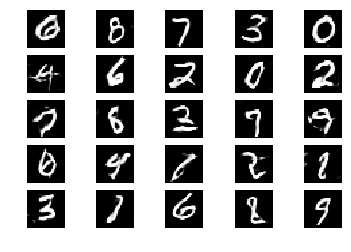

10000 [D loss: 0.626750, acc.: 64.06%] [G loss: 1.286826]


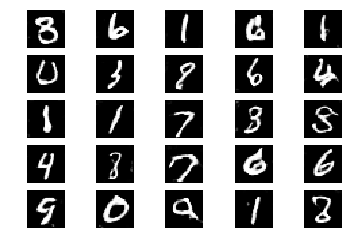

12000 [D loss: 0.454431, acc.: 84.38%] [G loss: 1.403336]


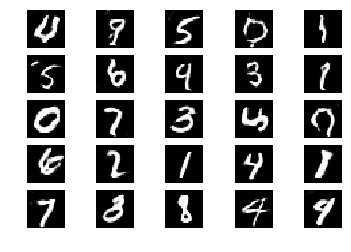

14000 [D loss: 0.286145, acc.: 90.62%] [G loss: 1.686064]


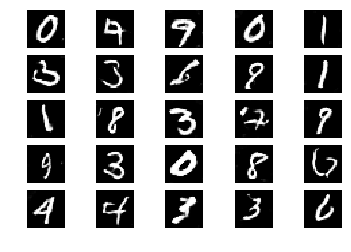

16000 [D loss: 0.329378, acc.: 90.62%] [G loss: 2.147266]


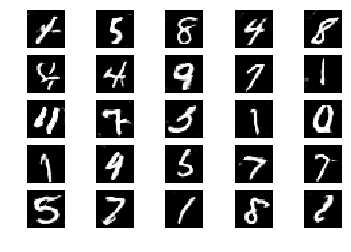

18000 [D loss: 0.447415, acc.: 84.38%] [G loss: 1.733637]


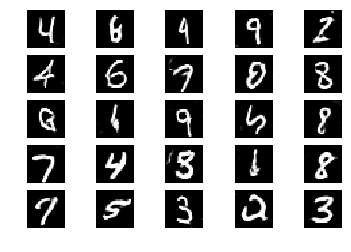

20000 [D loss: 0.475501, acc.: 81.25%] [G loss: 2.017759]


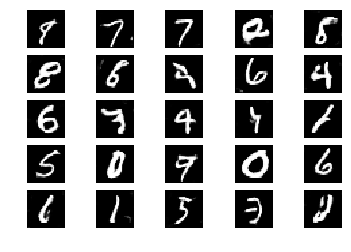

22000 [D loss: 0.334326, acc.: 85.94%] [G loss: 1.206992]


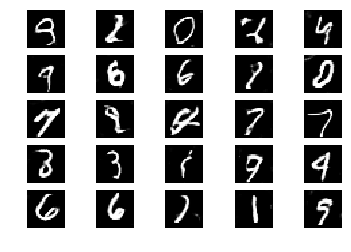

24000 [D loss: 0.699727, acc.: 59.38%] [G loss: 1.447559]


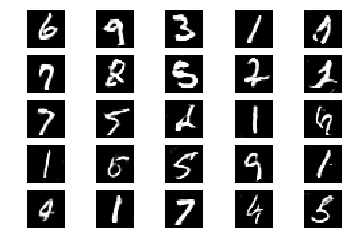

26000 [D loss: 0.749535, acc.: 54.69%] [G loss: 1.387443]


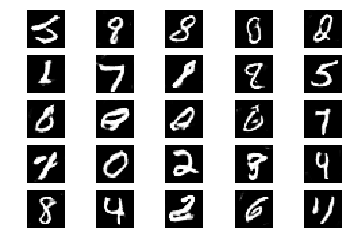

28000 [D loss: 0.425959, acc.: 84.38%] [G loss: 1.772788]


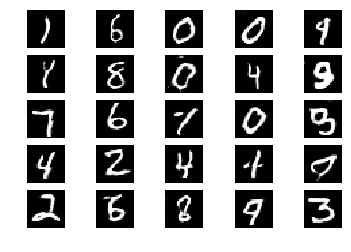

30000 [D loss: 0.459264, acc.: 73.44%] [G loss: 2.614447]


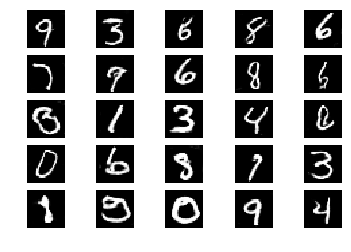

32000 [D loss: 0.311763, acc.: 90.62%] [G loss: 0.966863]


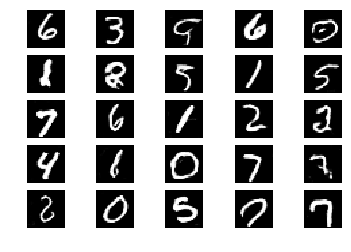

34000 [D loss: 0.316047, acc.: 92.19%] [G loss: 1.571629]


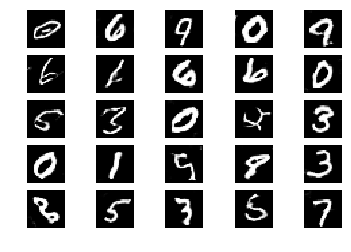

36000 [D loss: 0.678074, acc.: 62.50%] [G loss: 0.872375]


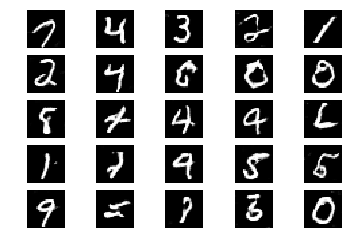

38000 [D loss: 0.476501, acc.: 75.00%] [G loss: 4.274796]


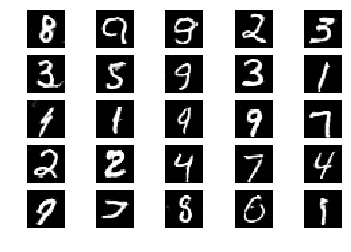

40000 [D loss: 0.170107, acc.: 95.31%] [G loss: 2.708914]


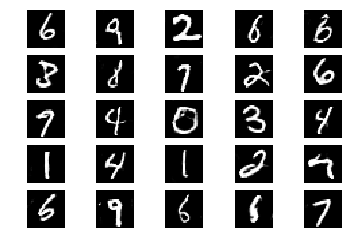

42000 [D loss: 0.553057, acc.: 62.50%] [G loss: 2.377417]


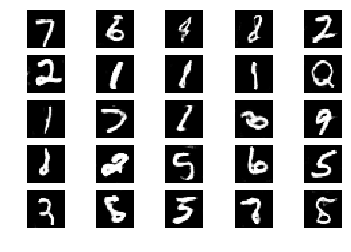

44000 [D loss: 0.389442, acc.: 85.94%] [G loss: 1.733038]


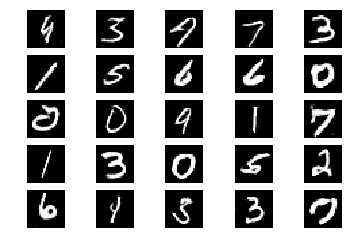

46000 [D loss: 0.705238, acc.: 59.38%] [G loss: 1.301688]


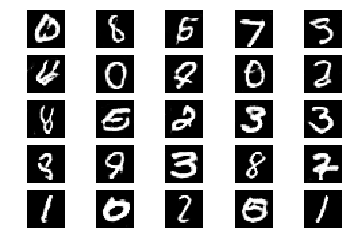

48000 [D loss: 0.486088, acc.: 64.06%] [G loss: 2.510082]


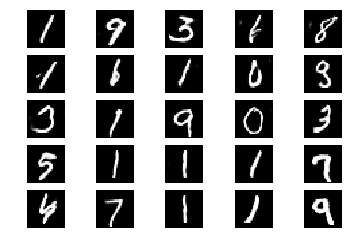

50000 [D loss: 0.487843, acc.: 79.69%] [G loss: 3.796224]


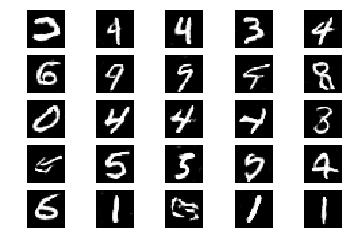

52000 [D loss: 0.227026, acc.: 95.31%] [G loss: 1.014030]


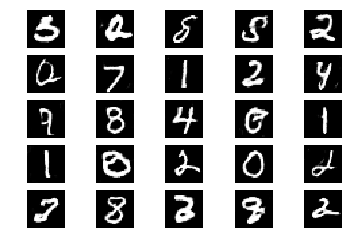

54000 [D loss: 0.462030, acc.: 75.00%] [G loss: 1.861607]


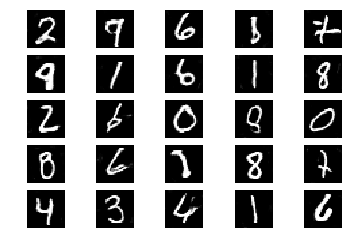

56000 [D loss: 0.338559, acc.: 92.19%] [G loss: 2.479788]


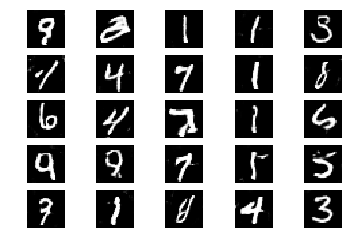

58000 [D loss: 0.533601, acc.: 73.44%] [G loss: 1.563395]


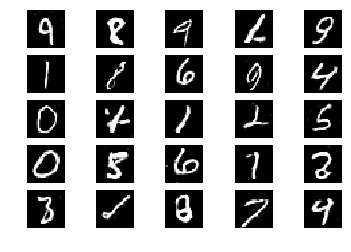

60000 [D loss: 0.435055, acc.: 79.69%] [G loss: 0.480650]


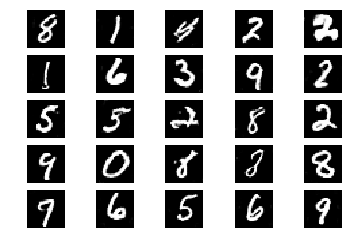

62000 [D loss: 0.340924, acc.: 87.50%] [G loss: 2.201936]


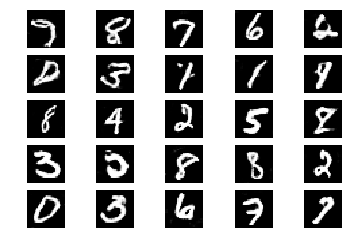

64000 [D loss: 0.107650, acc.: 100.00%] [G loss: 2.879936]


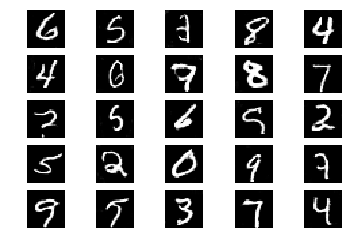

66000 [D loss: 0.210118, acc.: 93.75%] [G loss: 2.045771]


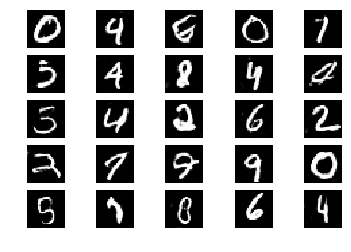

68000 [D loss: 0.462280, acc.: 78.12%] [G loss: 3.477702]


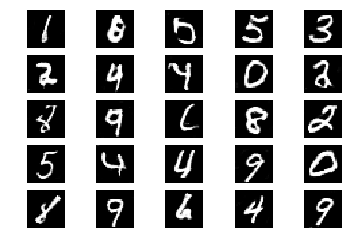

In [25]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

img_shape = (28,28,1)
latent_dim = 100
save_path = 'images-70k'
n_iter = 70000
scaling = 127.5
model_class = DCGAN
  
# Train model
gan = model_class(X_train, img_shape, latent_dim, save_path)
gan.train(n_iter, 32, 2000, scaling)

In [5]:
!ls

drive  images  images-70k  sample_data


In [0]:
def get_samples(samples, save_path):
  # Load generator
  gen = load_model(save_path + '/models/68000/gen_68000.h5')

  # Get samples
  noise = np.random.normal(0, 1, (samples, 100))
  gen_imgs = gen.predict(noise)
  
  return gen_imgs

def aug_mnist(model_path):
  # Get real data
  (X_train, _), (X_test, _) = mnist.load_data()

  # Generate fake dataset
  fake_train = get_samples(X_train.shape[0], model_path)
  fake_test = get_samples(X_test.shape[0], model_path)

  # Create dataset
  X_train = np.vstack((X_train, fake_train[:,:,:,0]))
  y_train = np.hstack((np.ones((fake_train.shape[0],)), np.zeros((fake_train.shape[0],))))

  X_test = np.vstack((X_test, fake_test[:,:,:,0]))
  y_test = np.hstack((np.ones((fake_test.shape[0],)), np.zeros((fake_test.shape[0],))))
  
  return (X_train, y_train), (X_test, y_test)

def create_cnn():
  model = Sequential()

  img_shape = (28,28,1)
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  
  # Compile the model
  model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

  model.summary()
  return model
  
def build_model(gen_path, e):
  (x_train, y_train), (x_test, y_test) = aug_mnist(gen_path)
  
  # Normalize 
  x_train = x_train/255
  x_test = x_test/255
  
  x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
  x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
  
  # Fit
  clf = create_cnn()
  clf.fit(x_train, y_train, epochs=e, batch_size=100)
  
  # Evaluate
  test_predictions = clf.predict(x_test)
  test_predictions = np.round(test_predictions)
  
  accuracy = accuracy_score(y_test, test_predictions)
  print("Accuracy: " + str(accuracy))
  
  return clf

In [7]:
save_path = 'images-70k'
m = build_model(save_path, 5)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
___________________________

In [8]:
layer_name = m.layers[-2].name
intermediate_layer_model = Model(inputs=m.input,
                                 outputs=m.get_layer(layer_name).output)

(x_train, y_train), (x_test, y_test) = aug_mnist(save_path)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
intermediate_output = intermediate_layer_model.predict(x_train.reshape(120000,28,28,1))

In [0]:
int_out_test = intermediate_layer_model.predict(x_test.reshape(20000,28,28,1))

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(intermediate_output)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
int_out = pca.transform(intermediate_output)
int_out[:,0] = 0
int_out = pca.inverse_transform(int_out)

In [0]:
a = pca.transform(int_out)

In [14]:
a[:,0]

array([-1.6528368e-04, -1.9264221e-04, -3.4523010e-04, ...,
       -8.6426735e-06,  1.3709068e-06, -5.3495169e-06], dtype=float32)

In [0]:
def get_new_layer():
  model = Sequential()
  model.add(Dense(1, activation='sigmoid', name='fc1', input_shape=(4096,)))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [33]:
# 2nd iter of training 
m2 = get_new_layer()
m2.fit(int_out, y_train, epochs=5, batch_size=100)

# Evaluate
test_predictions2 = m2.predict(int_out_test)
test_predictions2 = np.round(test_predictions2)

accuracy = accuracy_score(y_test, test_predictions2)
print("Accuracy: " + str(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 1)                 4097      
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
120000/120000 [==============================] - 5s 43us/step - loss: 8.0583 - acc: 0.4996
Epoch 2/5
120000/120000 [==============================] - 4s 37us/step - loss: 8.0590 - acc: 0.5000
Epoch 3/5
120000/120000 [==============================] - 4s 37us/step - loss: 8.0590 - acc: 0.5000
Epoch 4/5
120000/120000 [==============================] - 4s 37us/step - loss: 8.0590 - acc: 0.5000
Epoch 5/5
120000/120000 [==============================] - 4s 37us/step - loss: 8.0590 - acc: 0.5000
Accuracy: 0.5
